# Difference Spec Code for SDSS and SAMI Spectra
Here are some of the important bits for reading in the files, taking the difference spectra and doing some calculations!

In [22]:
import matplotlib.pyplot as plt
import pylab as py
import numpy as np
import scipy as sp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.constants import c
import spectres
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from PyAstronomy import pyasl
from scipy.ndimage import gaussian_filter1d
from lmfit.models import GaussianModel
from astropy.cosmology import Planck18 as cosmo
import os

## Reading functions
slightly edited versions of the original functions from Scott + extras

In [23]:
def sami_read_apspec(filename,extname,var_extname,doareacorr=False,bugfix=True):
    hdulist = fits.open(filename)
    sami_flux = hdulist[extname].data
    header = hdulist[extname].header
    crval1=header['CRVAL1']
    cdelt1=header['CDELT1']
    crpix1=header['CRPIX1']
    naxis1=header['NAXIS1']
    x=np.arange(naxis1)+1
    L0=crval1-crpix1*cdelt1 #Lc-pix*dL        
    sami_lam = L0+x*cdelt1

    if (doareacorr):
        # fix bug in ap spec code:
        if (bugfix):
            areacorr=areacorr/2.0
        areacorr = header['AREACORR']
        sami_flux = sami_flux * areacorr

    #convert SAMI (wavelength in air) to wavelength in vacuum By default, the conversion specified by Ciddor 1996 are used.
    samivac_lam = pyasl.airtovac2(sami_lam)
    
    sami_flux = sami_flux*10 # flux unit conversion from 10e16 to 10e17 to match sdss

    
    sami_var = hdulist[var_extname].data #extract the variance array
    hdulist.close()
    return sami_flux, samivac_lam, sami_var


def sdss_read(infile):

    # get basic info on file:
    
    # opening file
    hdulist = fits.open(infile)
    # read spectrum from COADD extension:
    sdss_spec_table = hdulist['COADD'].data
    sdss_flux = sdss_spec_table['flux']
    sdss_loglam = sdss_spec_table['loglam']
    # SDSS spectra are in log wavelength bins, to convert to linear:
    sdss_lam = 10.0**sdss_loglam
    # inverse variance
    sdss_ivar = sdss_spec_table['ivar']
    # close fits file:
    hdulist.close()

    # define parts of spectrum where data is likely to be good:
    idx = np.where((sdss_lam>3900) & (sdss_lam<9000))
    sdss_flux = sdss_flux[idx]
    sdss_lam = sdss_lam[idx]
    sdss_ivar = sdss_ivar[idx]

    return sdss_flux, sdss_lam, sdss_ivar


def gaussian_blur(RA, RB, lam, flux_B, wavelength_step): 
    """
    Gaussian convolution/blurring - to reconcile between spectra with different resolutions
    This was used when SAMI/SDSS were used together


    Parameters:
    RA, RB = resolutions. RA = lower res
    lam = shared wavelength array. should be the same for A & B since resampling (using spectres) should be done first
    flux_B = flux array of higher res
    wavelength_step = pixel width of shared wavelength array lam

    returns
    blurred_flux_B = blurred flux array for B
    """
    med = np.median(lam)
    FWHM_A = med / RA
    FWHM_B = med / RB
    sigma_A = FWHM_A / 2.355
    sigma_B = FWHM_B / 2.355
    sigma_kernel = np.sqrt(sigma_B**2 - sigma_A**2)

    # data
    blurred_flux_B = gaussian_filter1d(flux_B, sigma=sigma_kernel / wavelength_step) # choose this wavelength step after already mapping the spectra - therefore this is the SDSS step
    return blurred_flux_B


In [24]:
dir = os.getcwd()
print(dir)

os.chdir('/Users/shaunparasher/Documents/VS Code/denison_2026_test')



/Users/shaunparasher/Documents/VS Code/denison_2026_test


## Example: Creating diff spec (2021-2001)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

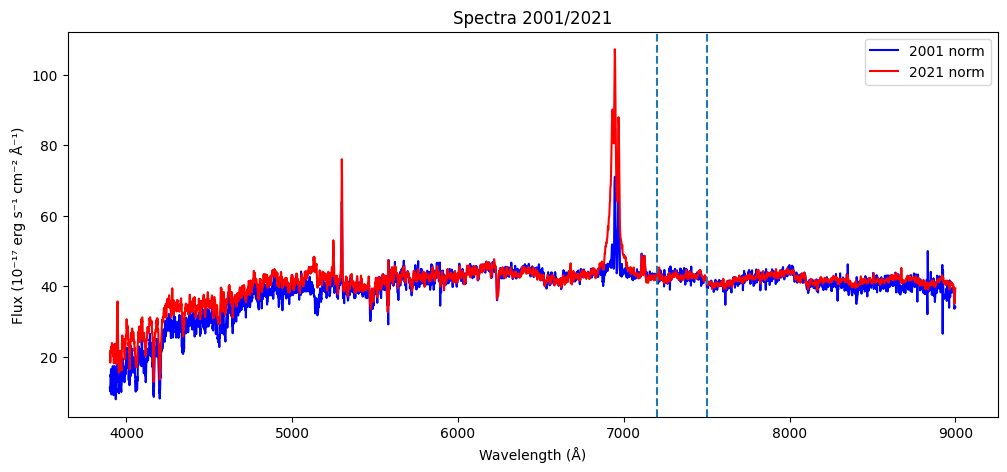

<Figure size 640x480 with 0 Axes>

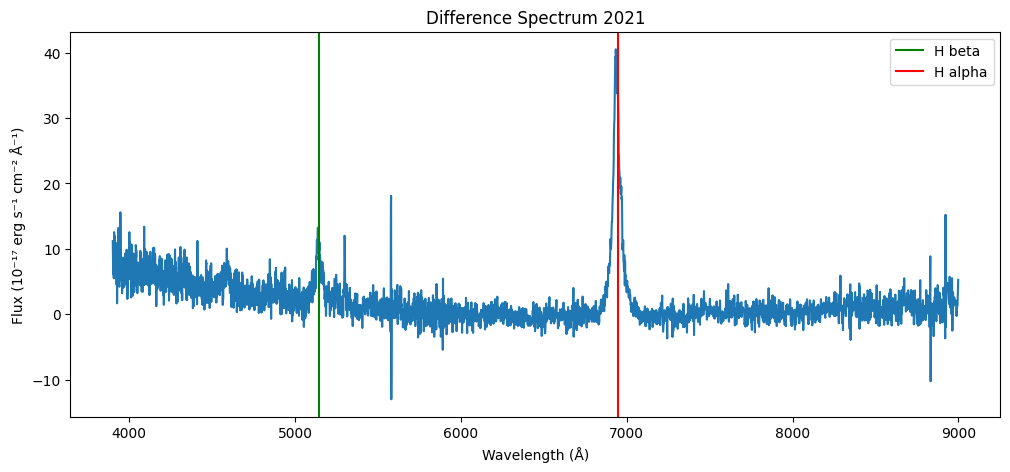

In [25]:
z = 1 + 0.0582

# reading in the files
flux01, lam01, ivar01 = sdss_read('shaun/Data/sami323854/sdss_data/spec-0469-51913-0338.fits') # 2001 file
flux21, lam21, ivar21 = sdss_read('shaun/Data/sami323854/sdss_data/spec-015167-59252-6747964707.fits') # 2021 file

# inverse variance -> variance
var01 = 1 / ivar01
var21 = 1 / ivar21


##now to normalise each one and calculate a new difference spectrum
nidx_21 = np.where((lam21 > 7200) & (lam21 < 7500))  #7200-7500A is a section with no significant spectral lines - baseline seciton
sec_21 = flux21[nidx_21]
mean_21 = np.mean(sec_21)

nidx_01 = np.where((lam01 > 7200) & (lam01 < 7500))
sec_01 = flux01[nidx_01]
mean_01 = np.mean(sec_01)
norm01 = flux01 * (mean_21 / mean_01) # normalising with baseline to match 2021 (trying to conserve integrated flux)



## mapping using spectres, returning the normalised flux values for SAMI based on SDSS sampling rate
flux21 = spectres.spectres(lam01, lam21, flux21)

# gaussian blurring here if necessary


## Uncertainty!!
# getting shifted variances to be able to compute with them point-wise
var21n = spectres.spectres(lam01, lam21, var21)
# accounts for normalization
a = mean_21 / mean_01
var_norm01 = (a**2) * var01

#plotting normalised spectra
plt.clf()
plt.figure(figsize=(12,5))
plt.plot(lam01, norm01, color='blue', label='2001 norm')
plt.plot(lam21, flux21, color='red', label='2021 norm')
plt.axvline(7200, linestyle='--')
plt.axvline(7500, linestyle='--')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Spectra 2001/2021")
plt.legend()
plt.show()



# diff spec
diff_spec = flux21 - norm01

#variance of diff spec
var_diff = var_norm01 + var21n
sigma_diff = np.sqrt(var_diff)


#plotting diff spec
plt.clf()
plt.figure(figsize=(12,5))
plt.plot(lam01, diff_spec)
plt.axvline(z*4862.68, color='g', label="H beta")
plt.axvline(z*6564.61, color='r', label="H alpha")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Difference Spectrum 2021")
plt.legend()


# Gaussian fit
fitting to the H alpha line!

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


[[Model]]
    (Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 313
    # variables        = 6
    chi-square         = 227.986571
    reduced chi-square = 0.74262727
    Akaike info crit   = -87.1948527
    Bayesian info crit = -64.7176336
    R-squared          = 0.98319617
[[Variables]]
    g0_amplitude:  1597.58802 +/- 48.0255553 (3.01%) (init = 1874.003)
    g0_center:     6942.87533 +/- 0.66900030 (0.01%) (init = 6934.259)
    g0_sigma:      36.2031828 +/- 0.92467855 (2.55%) (init = 18.46218)
    g0_fwhm:       85.2519789 +/- 2.17745153 (2.55%) == '2.3548200*g0_sigma'
    g0_height:     17.6046798 +/- 0.87371499 (4.96%) == '0.3989423*g0_amplitude/max(1e-15, g0_sigma)'
    g1_amplitude:  650.555250 +/- 47.5032349 (7.30%) (init = 32.50017)
    g1_center:     6936.64141 +/- 0.35818535 (0.01%) (init = 6940.646)
    g1_sigma:      12.1903388 +/- 0.50818706 (4.17%) (i

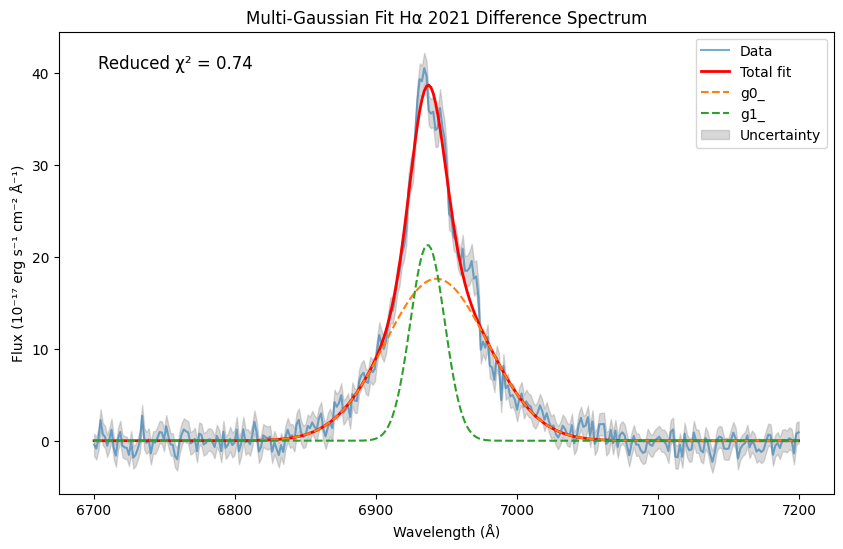

In [26]:
# limiting range to close to the H alpha line
idx = np.where((lam01 > 6700) & (lam01 < 7200))
x = lam01[idx]
y = diff_spec[idx]
sig = sigma_diff[idx]
sig[sig == 0] = np.min(sig[sig > 0]) ## dealing with division by 0

# Compute weights for the fitting
weights = 1.0 / sig

# establishing initial guesses for the fit
peaks, properties = find_peaks(y, height=np.std(y)*3, distance=3)  # tweak height/distance
peaks = peaks[:2]       ## change this depending on how many peaks you want captured
mu_guesses = x[peaks]
amp_guesses = properties["peak_heights"]
results_half = peak_widths(y, peaks, rel_height=0.5)
sigma_guesses = results_half[0] * (x[1] - x[0]) / (2*np.sqrt(2*np.log(2)))  # convert FWHM → stddev


# perform the fit:
model = None
params = None

for i, (amp, mu, sigma) in enumerate(zip(amp_guesses, mu_guesses, sigma_guesses)):
    prefix = f"g{i}_"
    g = GaussianModel(prefix=prefix)
    if model is None:
        model = g
        params = g.make_params()
    else:
        model += g
        params.update(g.make_params())
    
    # set parameter guesses
    params[prefix+'amplitude'].set(value=amp*np.sqrt(2*np.pi)*sigma, min=0)
    params[prefix+'center'].set(value=mu)
    params[prefix+'sigma'].set(value=sigma, min=0.1)


result = model.fit(y, params, x=x, weights=weights)
print(result.fit_report()) #uncomment if you want the fit report!


# Plot the outcome!
redchisq = result.redchi    # lmfit stores reduced chisq here
plt.figure(figsize=(10,6))
plt.plot(x, y, label="Data", alpha=0.6)
plt.plot(x, result.best_fit, 'r-', label="Total fit", linewidth=2)

# Plot each component separately
for name, comp in result.eval_components(x=x).items():
    plt.plot(x, comp, '--', label=name)

# Plot uncertainty band (gray stripe)
plt.fill_between(
    x,
    y - sig,
    y + sig,
    color="gray",
    alpha=0.3,
    label="Uncertainty"
)
plt.ylabel('Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)')
plt.xlabel("Wavelength (Å)")
plt.title("Multi-Gaussian Fit Hα 2021 Difference Spectrum")
    
plt.text(
    0.05, 0.95,         
    f"Reduced χ² = {result.redchi:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.legend()
plt.show()

## Extracting fit parameters with monte carlo sampling
for the full width at half maximum and the luminosity (from integrated flux)

note: if you only fit one gaussian, you can find the fwhm + uncertainty in the fit report

In [27]:
def fwhm_from_fit(x, y, sig, model, params, n_trials):
    # n_trials = no. of monte carlo samples
  fwhm_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
    y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

    result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) # refit model

    #compute fwhm
    y_fit_mc = result_mc.best_fit
    half_max = np.max(y_fit_mc) / 2
    above_half = np.where(y_fit_mc >= half_max)[0]
    if len(above_half) > 1:
      fwhm = x[above_half[-1]] - x[above_half[0]]
      fwhm_list.append(fwhm)

  # extract values
  fwhm_mean = np.mean(fwhm_list) * u.AA
  fwhm_std = np.std(fwhm_list) * u.AA

  # convert to km/s
  rest_wavelength = 6562.8 * u.AA  # Hα rest wavelength
  fwhm_vel = (fwhm_mean / rest_wavelength) * c.to(u.km/u.s)
  fwhm_vel_err = (fwhm_std / rest_wavelength)* c.to(u.km/u.s)

  return fwhm_vel, fwhm_vel_err


In [28]:
def lum_from_fit(x, y, sig, model, params, n_trials):
  trapflux_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
      y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

      result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) #refit model

      y_fit_mc = result_mc.best_fit
      trapflux = np.trapz(y_fit_mc, x)  #integrate with trapezoidal rule
      trapflux_list.append(trapflux)

  # extract values: mean and sd of the sampled integrals
  trap_mean = np.mean(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  trap_std = np.std(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  
  # Luminosity distance
  z = 0.0582
  d = cosmo.luminosity_distance(z)
  d = d.to(u.cm)

  # compute luminosity
  luminosity = trap_mean * 4 * np.pi * (d**2)
  lum_err = trap_std * 4 * np.pi * (d**2)

  return luminosity, lum_err


Note: this will take a while to run! lower the number of samples to test

In [29]:
fwhm_velocity_ha, fwhm_vel_err_ha = fwhm_from_fit(x, y, sig, model, params, 500)
luminosity_ha, lum_err_ha = lum_from_fit(x, y, sig, model, params, 500)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by AffineScalarFunc.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:491: FutureWarning: AffineScalarFunc.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:526: FutureWarning: AffineScalarFunc.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instan

In [30]:
print(f"fwhm: {fwhm_velocity_ha:.2e} ± {fwhm_vel_err_ha:.2e} ")
print(f"luminosity: {luminosity_ha:.2e} ± {lum_err_ha:.2e} ")

fwhm: 2.10e+03 km / s ± 3.13e+02 km / s 
luminosity: 1.91e+41 erg / s ± 6.03e+39 erg / s 


### Then to find BH mass!

In [31]:
def bh_mass(l_ha, l_ha_err, fwhm_ha, fwhm_ha_err):
    """
    Estimate BH mass from Halpha line. Using the equation from Greene & Ho 2005
    
    Parameters:
    l_ha : Halpha luminosity in erg/s (with error l_ha_err)
    fwhm_ha : Halpha line FWHM in km/s (with error fwhm_ha_err)

    Returns:
    mbh : Black hole mass in solar masses (with error mbh_err)
    Note: mbh_err calculated using log(mass) for easier calculation
    """
    coeff = 2.0e6  
    exp_l = 0.55
    exp_fwhm = 2.06

    # Normalize inputs
    l_norm = l_ha / 1e42
    fwhm_norm = fwhm_ha / 1e3 
    mbh = coeff * (l_norm**exp_l) * (fwhm_norm**exp_fwhm)

    # uncertainty (using log(mass))
    sig_loglum = (1/np.log(10)) * (l_ha_err / l_ha)
    sig_logfwhm = (1/np.log(10)) * (fwhm_ha_err / fwhm_ha)
    sig_loga = (1/np.log(10)) * (0.35 / 2)
    sig_b = 0.02
    sig_c = 0.06
    b = 0.55
    c = 2.06

    
    var_logm = (sig_loga)**2 + (np.log10(l_ha/(10**42)) * sig_b)**2 + (b*sig_loglum)**2 + (np.log10(fwhm_ha/(10**3)) * sig_c)**2 + (c*sig_logfwhm)**2

    sig_logm = np.sqrt(var_logm)
    mbh_err = np.log(10) * mbh * sig_logm

    return mbh, mbh_err


mass, sig_m = bh_mass(luminosity_ha.value, lum_err_ha.value, fwhm_velocity_ha.value, fwhm_vel_err_ha.value)
print(f"Estimated black hole mass: {mass:.2e} ± {sig_m:.2e} M_sun")

Estimated black hole mass: 3.70e+06 ± 1.33e+06 M_sun
